In [1]:
import torch
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import random
import re

from parrot import Parrot
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA


import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math

C:\Users\khant\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [145]:
import warnings
warnings.filterwarnings("ignore")

In [127]:
torch.manual_seed(4042)

# IMDB data set exploration

In [2]:
imdb = pd.read_csv("IMDB Dataset.csv")
imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
# clean reviews
imdb['review'] = imdb['review'].apply(lambda x: re.sub(r'<br\s*/?>', '', x, flags=re.IGNORECASE))

# Exploring Paraphrasing models

In [147]:
# Humarin's paraphraser based on chatgpt

tokenizer_p = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

n = 4 # Generate n paraphrases

def paraphrase(
    question,
    num_beams= n,
    num_beam_groups= n,
    num_return_sequences= n,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = tokenizer_p(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids
    
    outputs = model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = tokenizer_p.batch_decode(outputs, skip_special_tokens=True)

    return res


In [5]:
# Prithivida's python paraphrase

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")

C:\Users\khant\AppData\Roaming\Python\Python39\site-packages\transformers\models\auto\tokenization_auto.py:640: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
C:\Users\khant\AppData\Roaming\Python\Python39\site-packages\transformers\models\auto\auto_factory.py:479: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\khant\AppData\Roaming\Python\Python39\si

In [151]:
# Testing our paraphraser

phrase = "this model is not performing up to my expectations"

print("Parrot output:")
para_phrases = parrot.augment(input_phrase=phrase, use_gpu=False, max_return_phrases = 4) # returns (string, len(string))
for para_phrase in para_phrases:
    print(para_phrase[0])
    
print("--------------------------------------------------------")

print("ChatGPT paraphraser output:")
para_phrases2 = paraphrase(phrase)
for para_phrase in para_phrases2:
    print(para_phrase)


Parrot output:
this model doesn't meet my expectations
this model doesn't deliver my expectations
this is not meeting my expectations
this model does not perform to my expectations
--------------------------------------------------------
ChatGPT paraphraser output:
This model is not meeting my expectations.
I am not satisfied with the performance of this model.
The quality of this model is not satisfactory.
My impressions of this model are not up to par.


In [7]:
phrase = " A welcome relief from baseball movies that try too hard to be mythic , this one is a sweet and modest and ultimately winning story ."

print("Parrot output:")
para_phrases = parrot.augment(input_phrase=phrase, use_gpu=False,max_length=len(phrase)) # returns (string, len(string))
for para_phrase in para_phrases:
    print(para_phrase[0])
    
print("--------------------------------------------------------")

print("Humarin's paraphraser output:")
para_phrases2 = paraphrase(phrase)
for para_phrase in para_phrases2:
    print(para_phrase)

Parrot output:
a welcome relief from baseball films that try too hard to be mythic this is a sweet and modest and ultimately winning story
a welcome relief from baseball films that try too hard to be mythic this one is a sweet and modest and ultimately winning story
a welcome relief from baseball movies that try too hard to be mythic this one is a sweet and modest and ultimately winning story
--------------------------------------------------------
Humarin's paraphraser output:
Unlike baseball movies that strive to be overhyped, this story is both humble and ultimately successful.
This baseball movie is a welcome change from the overly ambitious and overblown tale of triumphant team members, as it's genuinely sweet and modest.
It's a welcome change from baseball movies that strive to be mythical, as it'll end up being genuinely sweet, modest, and ultimately successful.


In [ ]:
phrase = imdb["review"].values[random.randint(0,50000)]
print(f'review: {phrase}')
print("--------------------------------------------------------")

print("Parrot output:")
para_phrases = parrot.augment(input_phrase=phrase, use_gpu=False) # returns (string, len(string))
for para_phrase in para_phrases:
    print(para_phrase[0])
    
print("--------------------------------------------------------")

print("Humarin's paraphraser output:")
para_phrases2 = paraphrase(phrase)
for para_phrase in para_phrases2:
    print(para_phrase)

*Parrot does not work for multi sentence strings 

# Validating paraphrasing models

### Sentence wise

In [11]:
# Using Nltk.vader's Sentiment intensity Analyser
sia = SIA()

In [12]:
phrase = 'This is an outstanding movie with a great cast. The plot is equally great'
base_score = sia.polarity_scores(phrase)['compound']
print(f'base score: {base_score}')

print("--------------------------------------------------------")

print("Humarin's paraphraser output:")
para_phrases2 = paraphrase(phrase)
for para_phrase in para_phrases2:
    para_score = sia.polarity_scores(para_phrase)['compound']
    print(f'para score: {para_score}')
    print(f'difference: {abs(para_score - base_score)}')
    
    

base score: 0.9217
--------------------------------------------------------
Humarin's paraphraser output:
para score: 0.8074
difference: 0.11429999999999996
para score: 0.9081
difference: 0.013599999999999945
para score: 0.8074
difference: 0.11429999999999996


In [13]:
phrase = imdb["review"].values[random.randint(0,50000)]
base_score = sia.polarity_scores(phrase)['compound']
print(f'base score: {base_score}')

print("--------------------------------------------------------")

print("Parrot output:")
para_phrases = parrot.augment(input_phrase=phrase, use_gpu=False) # returns (string, len(string))
for para_phrase in para_phrases:
    para_score = sia.polarity_scores(para_phrase[0])['compound']
    print(f'para score: {para_score}')
    print(f'difference: {abs(para_score - base_score)}')


base score: -0.9568
--------------------------------------------------------
Parrot output:
para score: -0.9568
difference: 0.0


In [14]:
phrase = imdb["review"].values[random.randint(0,50000)]
base_score = sia.polarity_scores(phrase)['compound']
print(f'base score: {base_score}')

print("--------------------------------------------------------")

print("Humarin's paraphraser output:")
para_phrases2 = paraphrase(phrase)
for para_phrase in para_phrases2:
    para_score = sia.polarity_scores(para_phrase)['compound']
    print(f'para score: {para_score}')
    print(f'difference: {abs(para_score - base_score)}')

base score: 0.9642
--------------------------------------------------------
Humarin's paraphraser output:
para score: 0.9136
difference: 0.05059999999999998
para score: 0.9325
difference: 0.03169999999999995
para score: 0.9698
difference: 0.005600000000000049


Sentence wise paraphrasing works better for parrot, if sentence is actually paraphrased

# Sentencewise paraphrasing

In [20]:
print(phrase)

i am totally addicted to this show. i can't wait till the week goes by to see the next showing. it's a great story line and it has the best actors and actresses on the show. i will tune in every week to watch it even if i am not home i always have my vcr set to tape monarch cove. simon rex is the best actor on the show. it is suspenseful and exciting. i think this show should stay on the air and i believe everyone should tune in to watch it. i saw the very first episode and actually i wasn't going to watch it but i was watching lifetime one day and i decided to watch it because it was on and i absolutely love it and right now it's my favorite show. i am really mean it.


In [23]:
sentences = phrase.split(".")

res = ['','','']
for s in sentences:
    print(s)
    para_phrase =paraphrase(s)
    for i in range(len(res)):
        res[i] += para_phrase[i]

for rs in res:
    para_score = sia.polarity_scores(rs)['compound']
    print(f'para score: {para_score}')
    print(f'difference: {abs(para_score - base_score)}')

    

i am totally addicted to this show
 i can't wait till the week goes by to see the next showing
 it's a great story line and it has the best actors and actresses on the show
 i will tune in every week to watch it even if i am not home i always have my vcr set to tape monarch cove
 simon rex is the best actor on the show
 it is suspenseful and exciting
 i think this show should stay on the air and i believe everyone should tune in to watch it
 i saw the very first episode and actually i wasn't going to watch it but i was watching lifetime one day and i decided to watch it because it was on and i absolutely love it and right now it's my favorite show
 i am really mean it

para score: 0.9648
difference: 0.0006000000000000449
para score: 0.9611
difference: 0.0030999999999999917
para score: 0.9593
difference: 0.004899999999999904


In [26]:
for rs in res:
    print(rs)
    print()

I am completely fixated on this show and it is my obsession.The next week is approaching and I'm eagerly anticipating the screening.The storyline is impressive and the actors and actresses on screen are outstanding.Even if I am not at home, I will watch it every week and have my VCR taped to record Monarch Cove.The most outstanding actor on the show is Simon Rex.The story is teeming with suspense and excitement.I am of the opinion that this show should continue to air and be viewed by all.I had no intention of watching the first episode, but instead, I watched Lifetime because it was shown and I loved it. It's my favorite show at the moment.I am genuinely unpleasant.What is the definition of "I don't want to be a robot," and what does it mean when someone says something like, "If I wanted to make sure that some of their actions were not harmful", etc.?

This show has become my absolute obsession.I'm eagerly anticipating the upcoming screening until the week following our show.The show'

Sentecewise paraphrasing produces better score but semantics will be lost

# Training using small dataset

In [119]:
small_db = imdb.sample(n = 200)
small_db['sentiment'].value_counts()

sentiment
positive    109
negative     91
Name: count, dtype: int64

In [120]:
l = []
for r in small_db['review'].values:
    l.append(len(r))
np.mean(l)

1389.355

## Sentence-wise

Takes a really long time.

In [42]:
sentence_db = small_db.copy()
polarity_s = []

reviews = sentence_db['review'].values
sentiments = sentence_db['sentiment'].values

for i in range(len(reviews)):
    base_score = sia.polarity_scores(reviews[i])['compound'] # Get sentiment of original review
    sentences = reviews[i].split(".") # Separate into sentences

    # Get new reviews paraphrased by sentences
    res = ['','','']
    for s in sentences:
        print(s)
        para_phrase =paraphrase(s)
        for j in range(len(res)):
            res[j] += para_phrase[j]

    # New review is added to dataframe if score difference is less than 0.2
    for rs in res:
        para_score = sia.polarity_scores(rs)['compound']
        diff = abs(para_score - base_score)
        print(f'difference: {diff}')
        if diff <= 0.2:
            new_row = {'review': rs, 'sentiment': sentiments[i]}
            sentence_db = pd.concat([sentence_db, pd.DataFrame([new_row])], ignore_index=True)
            polarity_s.append(diff)
    print(f'Review {i+1} done.')
    

The real life case of an innocent First Nations chief(the Indian) by an Winnipeg city officer(the Cowboy) is the basis of this TV movie
 The actual case caused its fair share of racial tension in Canada, a small scale Martin Luther King thing
 The misjustice of First Nations people is becoming a staple in the Canadian cinema diet
 What makes this film worth viewing is the focus on the family's reactions
 The father played by Gordon Tootoosis demands forgiveness and the brother played by Eric Schweig demands justice
 The stars Gordon Tootoosis and Adam Beach(WINDTALKERS, SKINWALKERS)have minor, almost cameo, appearances
 Soon-to-be star Eric Schweig makes his mark in this film with a powerful performance
 An honourable mention goes to veteran actor Gary Chalk who has chalked up over 100 movies to his credit
 His portrayal of the troubled soul Inspector Dowson was worthy of a Gemini Award(the Canadian Emmy)along with Eric Schweig
 The special effects(jump cuts, dream sequences) are occas

 Gum disease is less painful
 No wonder, with the exception of Corner Gas, Canadians generally avoid Canadian TV
 Come on CBC you're suppose to be our leading station showcasing the best of Canadian talent
 Pull the plug on this amateurish mess

difference: 0.042099999999999915
difference: 0.0042000000000000925
difference: 0.033399999999999985
Review 6 done.
I wish I could give this movie a zero, or even lower, because sadly that's what it deserves
 I honestly never walk out of a movie, but this one was so dreadfully awful that I couldn't stand another minute of it
 Please,please, please- for the sake of mankind- skip this movie
 If you want a hot lesbian movie that you can really delve into, this isn't it
It has unattractive, unappealing leads, choppy structure, ridiculous dialog, and it is absolutely unconvincing in every imaginable way
 On an absolutely basic level, it fails to entertain
 Everything about "Mango Kiss" is so stagey, it is WORSE than any student film I have seen
As if

 Throw in a bunch of very colorful supporting characters (such as the guy with the chopsticks and the policemen) and "Pickup on South Street" treats you to a splendor of personalities as they hunt down the mysterious and accidentally stolen microfilm frames
--PolarisDiB
difference: 0.8823000000000001
difference: 0.025800000000000045
difference: 0.09720000000000006
Review 13 done.
I saw the The Bourne Ultimatum last summer with a friend, and, wow! I had already seen the first two films and I liked them, but Ultimatum, I loved
Matt Damon plays Jason Bourne, a amnesia suffering CIA agent on the run, trying to discover who he is
Like I already said, I loved this movie from start to finish, no plot holes, slow scenes, everything was paced just right and it fit in well with the other films, but in all senses it was much better
Best stunts, car chases, actors, and effects I've seen in an action movie all summer, (surprisingly due to Spider-Man 3, Pirates, etc
) But I it wasn't just action in 

 After the euphoria of the fabulous ending wore off, I concluded that they are equal in their excellence
 I am just confused about why its not in the Top 50 along with Memento
 I'm going to venture a guess that (sadly) it's because it's in black and white or because (again sadly)that the characters all have British accents 


sadly because that is no reason to not appreciate a great movie like this
I'm telling you that if you loved Memento, you will love Following as well
 Brilliant!
difference: 0.0021999999999999797
difference: 0.04400000000000004
difference: 0.06169999999999998
Review 17 done.
This is the most cliche ridden and worst romantic comedy I have ever seen
 Every scene is cringe worthy and the two lead actors - Corey and Danny are soo annoying
 Corey is very dumb and naive and should have never listened to Danny's false promises
Neve Campbell and the killer from Urban Legend are the only redeeming qualities in this poor attempt of a film
 Danny (Dean Paras) looks in his lat

<AxesSubplot:>

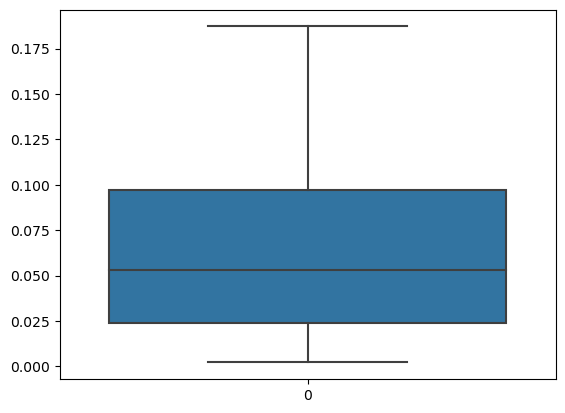

In [47]:
sb.boxplot(polarity_s)

In [48]:
print(len(sentence_db))
sentence_db["sentiment"].value_counts()

57


sentiment
positive    39
negative    18
Name: count, dtype: int64

# Whole review wise

In [125]:
para_db = small_db.copy()
polarity_p = []

reviews = para_db['review'].values
sentiments = para_db['sentiment'].values

for i in range(len(reviews)):
    base_score = sia.polarity_scores(reviews[i])['compound'] # Get sentiment of original review

    # New review is added to dataframe if score difference is less than 0.2
    new_reviews = paraphrase(reviews[i])
    for new_r in new_reviews:
        para_score = sia.polarity_scores(new_r)['compound']
        diff = abs(para_score - base_score)
        print(f'difference: {diff}')
        if diff <= 0.2:
            new_row = {'review': new_r, 'sentiment': sentiments[i]}
            para_db = pd.concat([para_db, pd.DataFrame([new_row])], ignore_index=True)
            polarity_p.append(diff)
    print(f'Review {i+1} done.')
    

C:\Users\khant\AppData\Roaming\Python\Python39\site-packages\transformers\generation\configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


difference: 0.029000000000000026
difference: 0.0685
difference: 0.06030000000000002
difference: 0.039899999999999936
Review 1 done.
difference: 0.05169999999999997
difference: 0.7173
difference: 0.28759999999999997
difference: 1.1268
Review 2 done.
difference: 0.014700000000000046
difference: 1.3005
difference: 0.8806
difference: 0.12380000000000002
Review 3 done.
difference: 0.17049999999999998
difference: 0.5858
difference: 0.7857999999999999
difference: 0.6046
Review 4 done.
difference: 0.38589999999999997
difference: 0.5039
difference: 0.4239
difference: 0.4541
Review 5 done.
difference: 0.19310000000000005
difference: 0.04049999999999998
difference: 0.034700000000000064
difference: 0.18369999999999997
Review 6 done.
difference: 0.3578
difference: 0.28259999999999996
difference: 0.1078
difference: 1.1917
Review 7 done.
difference: 0.9921
difference: 1.0693
difference: 1.3739
difference: 0.9921
Review 8 done.
difference: 1.5379999999999998
difference: 0.9402999999999999
difference: 

difference: 1.3045
difference: 0.20440000000000003
difference: 0.2922
difference: 0.10619999999999996
Review 72 done.
difference: 0.07520000000000004
difference: 0.03499999999999992
difference: 0.3162
difference: 0.6344
Review 73 done.
difference: 1.0498
difference: 0.32130000000000003
difference: 1.8193000000000001
difference: 0.9495
Review 74 done.
difference: 0.10170000000000001
difference: 0.7559
difference: 0.12220000000000009
difference: 0.01860000000000006
Review 75 done.
difference: 1.1805999999999999
difference: 0.476
difference: 0.3596999999999999
difference: 1.3539999999999999
Review 76 done.
difference: 0.024800000000000044
difference: 0.7882
difference: 0.10340000000000005
difference: 0.19669999999999999
Review 77 done.
difference: 0.1612
difference: 0.34650000000000003
difference: 0.17510000000000003
difference: 0.19289999999999996
Review 78 done.
difference: 0.15249999999999997
difference: 0.47859999999999997
difference: 0.09060000000000001
difference: 0.2925999999999999

difference: 0.14800000000000002
difference: 0.1452
difference: 0.04749999999999999
difference: 0.13280000000000003
Review 140 done.
difference: 0.5983
difference: 0.12160000000000004
difference: 0.7137
difference: 1.3413
Review 141 done.
difference: 0.7388
difference: 0.8919
difference: 0.02939999999999998
difference: 0.06480000000000008
Review 142 done.
difference: 0.6535
difference: 0.0816
difference: 0.2717
difference: 0.6535
Review 143 done.
difference: 0.36019999999999996
difference: 1.0997999999999999
difference: 1.1251
difference: 0.39769999999999994
Review 144 done.
difference: 1.5925
difference: 1.6966
difference: 1.283
difference: 0.46319999999999995
Review 145 done.
difference: 0.46690000000000004
difference: 0.37439999999999996
difference: 0.4462
difference: 1.0598
Review 146 done.
difference: 0.38670000000000004
difference: 1.3198
difference: 0.5960000000000001
difference: 1.9168
Review 147 done.
difference: 0.1053
difference: 1.1221
difference: 0.44260000000000005
differe

In [126]:
print(len(para_db))
para_db["sentiment"].value_counts()

472


sentiment
positive    285
negative    187
Name: count, dtype: int64

# Parameters and model building

In [128]:
test = imdb.sample(n = 40)
test['sentiment'].value_counts()

sentiment
positive    22
negative    18
Name: count, dtype: int64

In [129]:
encoder = LabelEncoder()
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# test

In [138]:
train_sentences = small_db['review'].values
train_labels = encoder.fit_transform(small_db['sentiment'].values)

# tokenize sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 100)          300000    
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 24)                3096      
                                                                 
 dense_21 (Dense)            (None, 1)                 25        
                                                                 
Total params: 387601 (1.48 MB)
Trainable params: 387601 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [139]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
6/6 [==============================] - 13s 765ms/step - loss: 0.6937 - accuracy: 0.5444 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 2/5
6/6 [==============================] - 3s 474ms/step - loss: 0.6796 - accuracy: 0.5500 - val_loss: 0.7030 - val_accuracy: 0.5000
Epoch 3/5
6/6 [==============================] - 3s 505ms/step - loss: 0.6552 - accuracy: 0.5778 - val_loss: 0.7140 - val_accuracy: 0.4500
Epoch 4/5
6/6 [==============================] - 3s 524ms/step - loss: 0.5861 - accuracy: 0.7333 - val_loss: 1.0779 - val_accuracy: 0.5000
Epoch 5/5
6/6 [==============================] - 4s 645ms/step - loss: 0.5228 - accuracy: 0.8389 - val_loss: 0.7184 - val_accuracy: 0.3000


In [140]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

1/1 [==============================] - 1s 1s/step
Accuracy of prediction on test set :  0.45


## test on whole paragraph paraphrase

In [141]:
train_sentences = para_db['review'].values
train_labels = encoder.fit_transform(para_db['sentiment'].values)

# tokenize sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 100)          300000    
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dense_22 (Dense)            (None, 24)                3096      
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 387601 (1.48 MB)
Trainable params: 387601 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
14/14 [==============================] - 13s 472ms/step - loss: 0.6876 - accuracy: 0.5613 - val_loss: 0.6186 - val_accuracy: 0.7917
Epoch 2/5
14/14 [==============================] - 5s 346ms/step - loss: 0.6724 - accuracy: 0.5825 - val_loss: 0.6055 - val_accuracy: 0.7917
Epoch 3/5
14/14 [==============================] - 4s 317ms/step - loss: 0.5890 - accuracy: 0.7288 - val_loss: 0.6142 - val_accuracy: 0.8125
Epoch 4/5
14/14 [==============================] - 4s 310ms/step - loss: 0.3851 - accuracy: 0.9151 - val_loss: 0.3448 - val_accuracy: 0.8750
Epoch 5/5
14/14 [==============================] - 4s 315ms/step - loss: 0.0851 - accuracy: 0.9811 - val_loss: 0.3157 - val_accuracy: 0.8542


In [143]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

1/1 [==============================] - 1s 1s/step
Accuracy of prediction on test set :  0.65
